# **Random Forest Classifier**

In [1]:
import pandas as pd

Import th dataset already splitted

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [3]:
print(f"Number of data points in the training set: {train_data.shape[0]}")
print(f"Number of data points in the test set: {test_data.shape[0]}")

Number of data points in the training set: 373598
Number of data points in the test set: 35406


Drop unused features

In [4]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [5]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

## Preprocessing Pipeline

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 

Given that this model supports both categorical and numerical features, in the various attempts to find the best model, combinations of both were tried out. This is why the pipeline also supports categorical features

In [7]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', "passthrough", cat_features)
    ])

## Decision Tree Model

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTEENN,  SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

Given the high amount of parameters and combinations of them, we decided to adopt a randomized search approach over the parameter space, given the high dimensionality of the latter 

NOTE: resempling is added in the preprocessing pipeline in order to be applied olny on training data.

In [9]:
resampling = SMOTETomek(sampling_strategy=0.50, random_state=42)
clf = DecisionTreeClassifier(random_state=1)

# Create the model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampling", resampling),
        ("clf", clf)]
)

# Define the hyperparameter grid
params = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_impurity_decrease': [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001],
    'clf__splitter': ['best', 'random'],
    'clf__max_depth': [3,4,5,6,7,8,9,10],
    'clf__min_samples_split': [30, 50, 70, 100, 120, 150, 200, 250],
    'clf__min_samples_leaf': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__class_weight': ['balanced'],
}

# Define the scoring metrics
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1"),
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=50, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('resampling',
                                              SMOTETomek(random_state=42,
                                                         sampling_strategy=0.5)),
                                             ('clf',...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores:

In [10]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

# extract and print metrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.6615, Std: 0.0168
Specificity - Mean: 0.7151, Std: 0.0127
Accuracy - Mean: 0.7080, Std: 0.0090
Precision - Mean: 0.2625, Std: 0.0044
Recall - Mean: 0.6615, Std: 0.0168
Roc_auc - Mean: 0.7224, Std: 0.0027
F1 - Mean: 0.3757, Std: 0.0030


### Test scores:

Accuracy: 0.696
Recall: 0.697
Precision: 0.282
Sensitivity: 0.697
Specificity: 0.696
F1 Score: 0.402
ROC AUC Score: 0.697


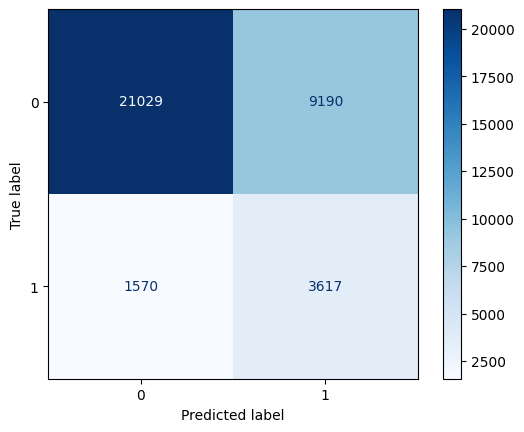

In [11]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [12]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     30219
           1       0.28      0.70      0.40      5187

    accuracy                           0.70     35406
   macro avg       0.61      0.70      0.60     35406
weighted avg       0.84      0.70      0.74     35406



### Best Decision Tree Plot

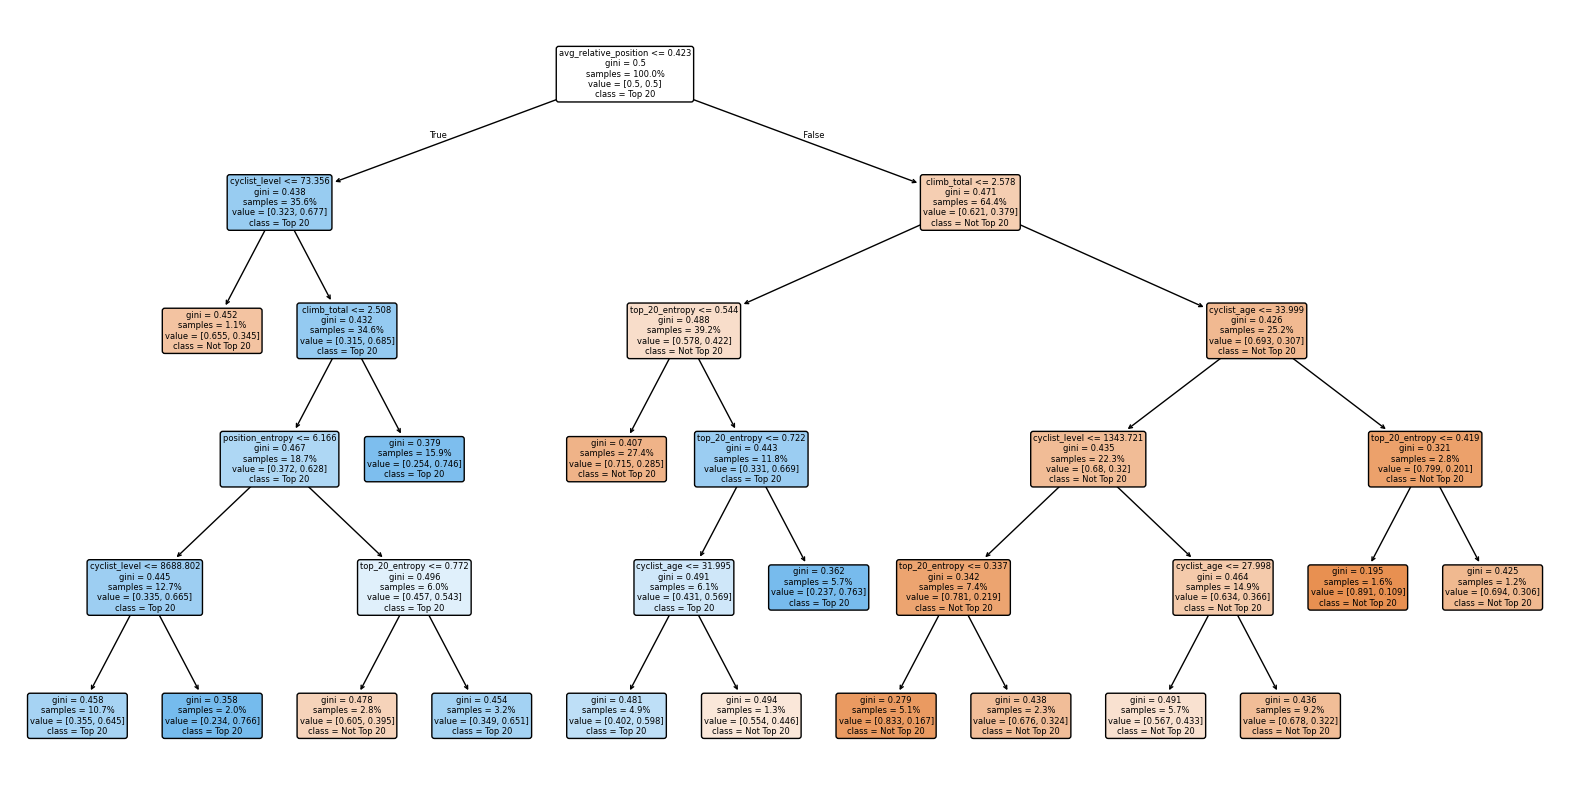

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

# take best model
best_model = rscv.best_estimator_
best_dt = best_model.named_steps["clf"]

preprocessor = best_model.named_steps["preprocessor"]
scaler = preprocessor.named_transformers_['num']

# Extract the thresholds and feature indices from the decision tree
thresholds = best_dt.tree_.threshold
feature_indices = best_dt.tree_.feature

# Rescaling the thresholds to original values
original_thresholds = np.array([
    (thresholds[i] * scaler.scale_[feature_indices[i]]) + scaler.mean_[feature_indices[i]]
    if feature_indices[i] != -2 else thresholds[i]  
    for i in range(len(thresholds))
])
best_dt.tree_.threshold[:] = original_thresholds

all_features = train_data.columns.tolist()

plt.figure(figsize=(20, 10))

plot_tree(
    best_dt,
    feature_names=all_features,
    class_names=['Not Top 20', 'Top 20'],
    filled=True,
    fontsize=6,
    proportion=True,
    rounded=True
)

plt.show()

The decision tree shows a clear structure with splits primarily driven by `avg_relative_position`, `cyclist_level`, and `cyclist_age`. The initial split on `avg_relative_position` effectively separates the data, highlighting its importance in predicting the target classes. Subsequent splits, particularly on `climb_total` and `cyclist_age`, refine the classification, though the tree depth in some branches suggests a tendency to overfit. The "Not Top 20" class dominates several paths, indicating a potential class imbalance. Overall, the tree captures key patterns in the data but appears to rely heavily on a few features, with some branches displaying redundancy in splits.

### Best Decision Tree Feature Importance

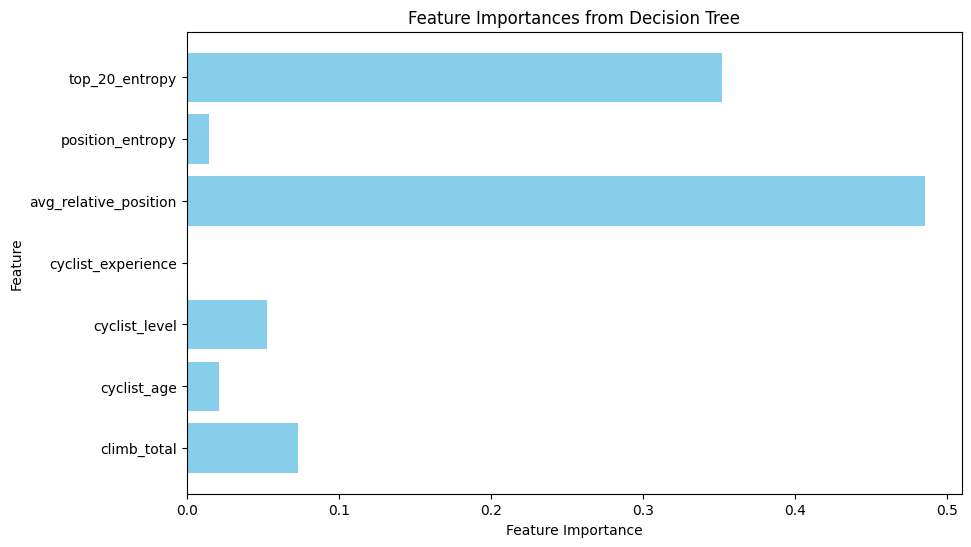

In [14]:
feature_importances = best_dt.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(all_features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

The feature importance plot reveals that the decision tree relies heavily on `avg_relative_position` and `top_20_entropy` to classify the data, with `avg_relative_position` contributing nearly 50% to the decision-making process. These features dominate the splits observed in the decision tree, aligning with their high discriminative power in separating the classes. Other features like `climb_total`, `cyclist_level`, and `cyclist_age` play a secondary role, while `position_entropy` and `cyclist_experience` contribute minimally. This imbalance in feature importance reflects the tree’s reliance on a few key predictors, which may explain the repetitive splits observed in the lower branches.

## Model Save

In [15]:
import joblib
import os

os.makedirs('best_models', exist_ok=True)
joblib.dump(best_model, 'best_models/dt.pkl')

['best_models/dt.pkl']

## Results: Resampling Techniques and Model Performance


Several combinations have been tested extensively, but the models do not perform well in any case due to the highly imbalanced nature of the dataset. Various input feature combinations were explored alongside different undersampling, oversampling, and hybrid techniques. In general, undersamplers overly simplified the task by reducing the dataset too much, leading to very simple trees that failed to generalize, despite acceptable validation results. On the other hand, oversamplers performed reasonably well, but the best results were achieved using hybrid techniques that combined oversampling with dataset cleaning, such as SMOTETomek.